In [9]:
import pickle
import pandas as pd
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn_evaluation import plot
import sklearn


RANDSTATE = 42

In [10]:
# full script for loadXy
def loadXy(data_dir, run_idx="1", xcolumns=["inj_i_mean", "ext_i_mean", "mid_i_mean"], ycolumns=["fcv1_i_mean"]):
    """
    Utility function for the specific data format.
    :param data_dir: directory to the data files
    :return: X (num_sample,input_dim), y (num_sample,), X_var (num_sample,)
    """
    # constant definitions
    time_column = ["unix_epoch_milliseconds_mean"]
    input_columns = ['inj_i_mean', 'inj_i_std', 'ext_i_mean', 'ext_i_std', 'mid_i_mean', 'mid_i_std', 'bias_v_mean', 'bias_v_std', 'gas_balzer_2_mean', 'gas_balzer_2_std']
    output_columns = ['fcv1_i_mean', 'fcv1_i_std']
    x_std_columns = [s.replace("mean", "std") for s in xcolumns]
    cuts = {
        "1": (1645222000, 1645512000),  # coils 'inj_i', 'ext_i', 'mid_i'
        "2": (1647625000, 1647845000),  # coils 'inj_i', 'ext_i', 'mid_i'
        "3": (1651285000, 1651476000),  # coils 'inj_i', 'ext_i', 'mid_i'
        "4": (1657920000, 1658173000),  # no beam current
        "5": (1662150000, 1662490000),  # bias_v, gas_balzer_2
        "6": (1663360000, 1663570000),  # bias_v, gas_balzer_2
        "7.0": (1664580000, 1664640000),  # bias_v, gas_balzer_2
        "7.5": (1664737000, 1664810000),  # bias_v, gas_balzer_2
        "8": (1665180000, 1665405000),  # bias_v, gas_balzer_2
    }
    # TODO: double check this with Damon
    x_scaler_dict = {
        "inj_i_mean": 1 / (130-117),
        "ext_i_mean": 1 / (110-97),
        "mid_i_mean": 1 / (110-95)
    }
    x_scalar = np.array([x_scaler_dict[s] for s in xcolumns])


    # reading data
    accumulated_data = pd.read_hdf(data_dir, "data")

    # extracting useful information
    data = accumulated_data[time_column+input_columns+output_columns]
    bounds = cuts[run_idx]
    run_data = data[(data["unix_epoch_milliseconds_mean"]/1000 > bounds[0]) & (data["unix_epoch_milliseconds_mean"]/1000 <= bounds[1])]
    run_data.describe()

    X = np.array(run_data[xcolumns]) * x_scalar
    y = np.array(run_data[ycolumns]).squeeze()
    X_var = (np.array(run_data[x_std_columns]) ** 2).sum(axis=1) # X_var = X1_std**2 + X2_std**2 + ...

    # dimension check
    assert(X.shape[0]==y.shape[0])
    assert(len(y.shape) == 1)
    assert(X.shape[0]==X_var.shape[0])

    return X, y, X_var

In [11]:
X, y, X_var = loadXy("../New Data/accumulated_weekend_data.h5")
X.shape, y.shape, X_var.shape

((1057, 3), (1057,), (1057,))

In [13]:
# hyper parameters
param_grid = [
  {'kernel__length_scale':[0.8, 1.0], 'kernel__nu':[0.66, 0.86]},
]

kernel = Matern(length_scale_bounds="fixed") 
kernel_RBF = RBF(length_scale_bounds="fixed")
#TODO: check if we want sklearn to autofit some of these paramters

gpr = GaussianProcessRegressor(
    kernel=kernel, alpha=X_var.mean(), n_restarts_optimizer=9
) 

clf = GridSearchCV(estimator=gpr, param_grid=param_grid)
clf.fit(X, y)
with open("../Results/gs_clf.dump" , "wb") as f:
    pickle.dump(clf, f)


## Result Inspection

In [18]:
with open("../Results/gs_clf.dump" , "rb") as f:
    clf_loaded = pickle.load(f)

<AxesSubplot:title={'center':'Grid search results'}, xlabel='kernel__length_scale', ylabel='Mean score'>

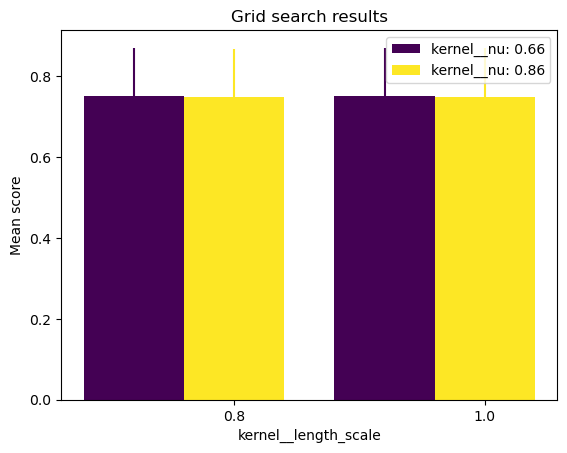

In [19]:
plot.grid_search(clf_loaded.cv_results_, change='kernel__length_scale', kind='bar')


In [20]:
clf_loaded.cv_results_

{'mean_fit_time': array([0.38084817, 0.38540354, 0.37104893, 0.30956922]),
 'std_fit_time': array([0.01563703, 0.00193995, 0.02150559, 0.01239623]),
 'mean_score_time': array([0.09195094, 0.09185634, 0.08882289, 0.08356533]),
 'std_score_time': array([0.00157447, 0.0004983 , 0.00812025, 0.01258294]),
 'param_kernel__length_scale': masked_array(data=[0.8, 0.8, 1.0, 1.0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel__nu': masked_array(data=[0.66, 0.86, 0.66, 0.86],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'kernel__length_scale': 0.8, 'kernel__nu': 0.66},
  {'kernel__length_scale': 0.8, 'kernel__nu': 0.86},
  {'kernel__length_scale': 1.0, 'kernel__nu': 0.66},
  {'kernel__length_scale': 1.0, 'kernel__nu': 0.86}],
 'split0_test_score': array([0.73995639, 0.73962805, 0.74004077, 0.74120765]),
 'split1_test_score': array([0.55897259, 0.54758571, 0.559